In [1]:
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Import data

In [2]:
# Select dataset
dataset = "commuter"

In [3]:
# Choose filepath
filepath = "../data/raw/commuter/jobs_and_job_density.csv"

# "../data/raw/commuter/regional_gross_domestic_product.csv"
# "../data/raw/commuter/jobs_and_job_density.csv"
# "../data/raw/commuter/total_final_energy_consumption_by_borough.csv" - This has NO data for 2001 

In [5]:
# Import Borough json
with open("../data/raw/misc/london_boroughs.json") as json_file:
    borough_coordinates = json.load(json_file)
    
data = pd.read_csv(filepath)

In [36]:
# Import origin supply,destination demand
orig_supply = np.loadtxt(f"../data/validation/{dataset}/borough_origin_supply.txt")
dest_demand = np.loadtxt(f"../data/validation/{dataset}/borough_destination_demand.txt")
# Import origin_locs,destination locations
destination_locs = np.loadtxt(f"../data/validation/{dataset}/borough_locations.txt")
origin_locs = np.loadtxt(f"../data/validation/{dataset}/borough_locations.txt")

In [37]:
# Normalise origin supply and destination demand
orig_supply_normalised = orig_supply/np.sum(orig_supply)
dest_demand_normalised = dest_demand/np.sum(dest_demand)

# Get Borough names

In [38]:
# Collect borough names
boroughs = []
boroughs_no_spaces = []

for f in tqdm(borough_coordinates['features']):
    boroughs.append(f['properties']['name'])
    boroughs_no_spaces.append(f['properties']['name'].replace(" ", ""))


100%|██████████| 33/33 [00:00<00:00, 32324.16it/s]


# Obtain destination size data by borough and year

In [39]:
# Select initial year
init_year = 2001 # 2001
# Select final year
final_year = 2005 # 2005
# Select variable
var = "number_of_jobs"
# Flag for normalising data
normalise = True

In [40]:
if "jobs_and_job_density" in filepath:
    # Map borough names
    data.loc[:,'name']=data['area'].map(dict(zip(np.sort(boroughs), np.sort(boroughs_no_spaces))))
    
    # Slice dataframe to get only London Boroughs
    data = copy.deepcopy(data[data['name'].isin(boroughs_no_spaces)])

    # Get initial and final year data
    init_year_data = copy.deepcopy(data[data['year']==init_year].sort_values(by='area'))
    final_year_data = copy.deepcopy(data[data['year']==final_year].sort_values(by='area'))

    # # Convert to numpy arrays
    init_year_array = init_year_data[var].values
    final_year_array = final_year_data[var].values

elif "total_final_energy_consumption_by_borough" in filepath:
    # Map borough names
    data.loc[:,'name']=data['Area'].map(dict(zip(np.sort(boroughs), np.sort(boroughs_no_spaces))))

    # Get initial and final year data
    init_year_data = copy.deepcopy(data[data['Year']==init_year].sort_values(by='Area'))
    final_year_data = copy.deepcopy(data[data['Year']==final_year].sort_values(by='Area'))

    # # Convert to numpy arrays
    init_year_array = init_year_data['Value'].values
    final_year_array = final_year_data['Value'].values

elif "regional_gross_domestic_product" in filepath:
    # Replace comma with nospace
    data = data.apply(lambda x: x.str.replace(',',''))
    
    # Map borough names
    data.loc[:,'name']=data['LA name'].map(dict(zip(np.sort(boroughs), np.sort(boroughs_no_spaces))))

    # Get initial and final year data
    init_year_data = copy.deepcopy(data[[str(init_year),"name"]].sort_values(by='name'))
    final_year_data = copy.deepcopy(data[[str(final_year),"name"]].sort_values(by='name'))

    # Convert to numpy arrays
    init_year_array = init_year_data[str(init_year)].values
    final_year_array = final_year_data[str(final_year)].values
    
    # Convert array to float
    init_year_array = init_year_array.astype(np.float)
    final_year_array = final_year_array.astype(np.float)
    

In [41]:
# Normalise data if required
if normalise:
    # Normalise data to sum up to 1
    init_year_array = init_year_array/np.sum(init_year_array)
    final_year_array = final_year_array/np.sum(final_year_array)

    # Take logs
    init_year_array = np.log(init_year_array)
    final_year_array = np.log(final_year_array)


# Sanity check

In [42]:
assert len(init_year_array) == len(boroughs)
assert len(final_year_array) == len(boroughs)

# Compare against destination demand

In [43]:
# Normalise initial destination sizes
init_year_array_normalised = init_year_array/np.sum(init_year_array)

In [44]:
print('Actual normalised latent sizes')
print(init_year_array_normalised)

Actual normalised latent sizes
[0.03681822 0.02903893 0.03409456 0.03047879 0.03062298 0.02276815
 0.02158732 0.02802242 0.0292828  0.03084409 0.03454898 0.03107126
 0.02999298 0.03409456 0.03355946 0.03276923 0.02660878 0.0283476
 0.02740798 0.02840306 0.03335473 0.02953406 0.03409456 0.03345646
 0.03366375 0.03335473 0.03305682 0.02638768 0.03387636 0.02745748
 0.03478588 0.02992584 0.0166895 ]


In [45]:
print('Actual normalised destination demand')
print(dest_demand_normalised)

Actual normalised destination demand
[0.01385306 0.02673902 0.01623919 0.02442689 0.02725171 0.06239545
 0.07564822 0.0343654  0.03003112 0.02246193 0.01824777 0.02029854
 0.02846336 0.01723526 0.01648445 0.01896139 0.03703827 0.02640187
 0.03801682 0.02860244 0.01562103 0.03149054 0.01829926 0.01757205
 0.01862818 0.01776869 0.01691241 0.0385767  0.01697033 0.04160674
 0.01644513 0.02759994 0.13934685]


In [46]:
print('Ratio of normalsied destination demand to normalised latent destination sizes ')
dest_demand_normalised/init_year_array_normalised

Ratio of normalsied destination demand to normalised latent destination sizes 


array([0.37625562, 0.92079907, 0.47629863, 0.80143917, 0.88991025,
       2.74047108, 3.50428898, 1.22635403, 1.0255548 , 0.72824092,
       0.52817112, 0.65328989, 0.94900093, 0.50551349, 0.49120138,
       0.57863403, 1.39195641, 0.93136169, 1.38707112, 1.00701975,
       0.4683302 , 1.06624461, 0.53672074, 0.5252213 , 0.55336016,
       0.53271863, 0.5116165 , 1.46192123, 0.50094913, 1.51531524,
       0.47275287, 0.92227773, 8.34937184])

### Visualise destination demand and latent destination sizes

In [47]:
dest_demand_normalised

array([0.01385306, 0.02673902, 0.01623919, 0.02442689, 0.02725171,
       0.06239545, 0.07564822, 0.0343654 , 0.03003112, 0.02246193,
       0.01824777, 0.02029854, 0.02846336, 0.01723526, 0.01648445,
       0.01896139, 0.03703827, 0.02640187, 0.03801682, 0.02860244,
       0.01562103, 0.03149054, 0.01829926, 0.01757205, 0.01862818,
       0.01776869, 0.01691241, 0.0385767 , 0.01697033, 0.04160674,
       0.01644513, 0.02759994, 0.13934685])

In [48]:
orig_supply_normalised

array([0.02061388, 0.04234396, 0.03035825, 0.03624706, 0.04245229,
       0.02795389, 0.00131891, 0.04632537, 0.04320524, 0.03622633,
       0.02853237, 0.02494888, 0.02571578, 0.02978764, 0.02776869,
       0.03052593, 0.0329993 , 0.02965929, 0.02514731, 0.02215124,
       0.02049911, 0.04151056, 0.03645085, 0.02862568, 0.02714624,
       0.03205972, 0.02481338, 0.03425064, 0.02518735, 0.02331535,
       0.03070291, 0.04411478, 0.02704184])

In [49]:
np.exp(init_year_array)

array([0.01178782, 0.03012443, 0.01637197, 0.02532198, 0.0248854 ,
       0.06417813, 0.07400131, 0.0340537 , 0.02925126, 0.02423052,
       0.0154988 , 0.02357564, 0.02685003, 0.01637197, 0.01746344,
       0.01920978, 0.0403842 , 0.03274394, 0.03667322, 0.03252565,
       0.01790002, 0.02837808, 0.01637197, 0.01768173, 0.01724514,
       0.01790002, 0.0185549 , 0.04147566, 0.01680856, 0.03645492,
       0.01506221, 0.02706833, 0.13359528])

In [50]:
np.exp(init_year_array)/orig_supply_normalised

array([ 0.57183896,  0.71142214,  0.53929229,  0.69859403,  0.58619685,
        2.29585682, 56.10777701,  0.73509836,  0.67703034,  0.66886487,
        0.54320063,  0.94495769,  1.04410742,  0.54962297,  0.62888943,
        0.6292938 ,  1.22378958,  1.10400297,  1.45833554,  1.46834432,
        0.87320956,  0.68363525,  0.44915193,  0.61768763,  0.63526825,
        0.55833372,  0.74777803,  1.21094563,  0.66734116,  1.56355913,
        0.49057939,  0.61358857,  4.94031781])

In [51]:
# Set plot params
latent_factor = 100000
actual_factor = 100000

In [52]:
len(actual_factor*np.exp(init_year_array))

33

In [53]:
len(actual_factor*orig_supply_normalised)

33

In [54]:
origin_locs.shape

(33, 2)

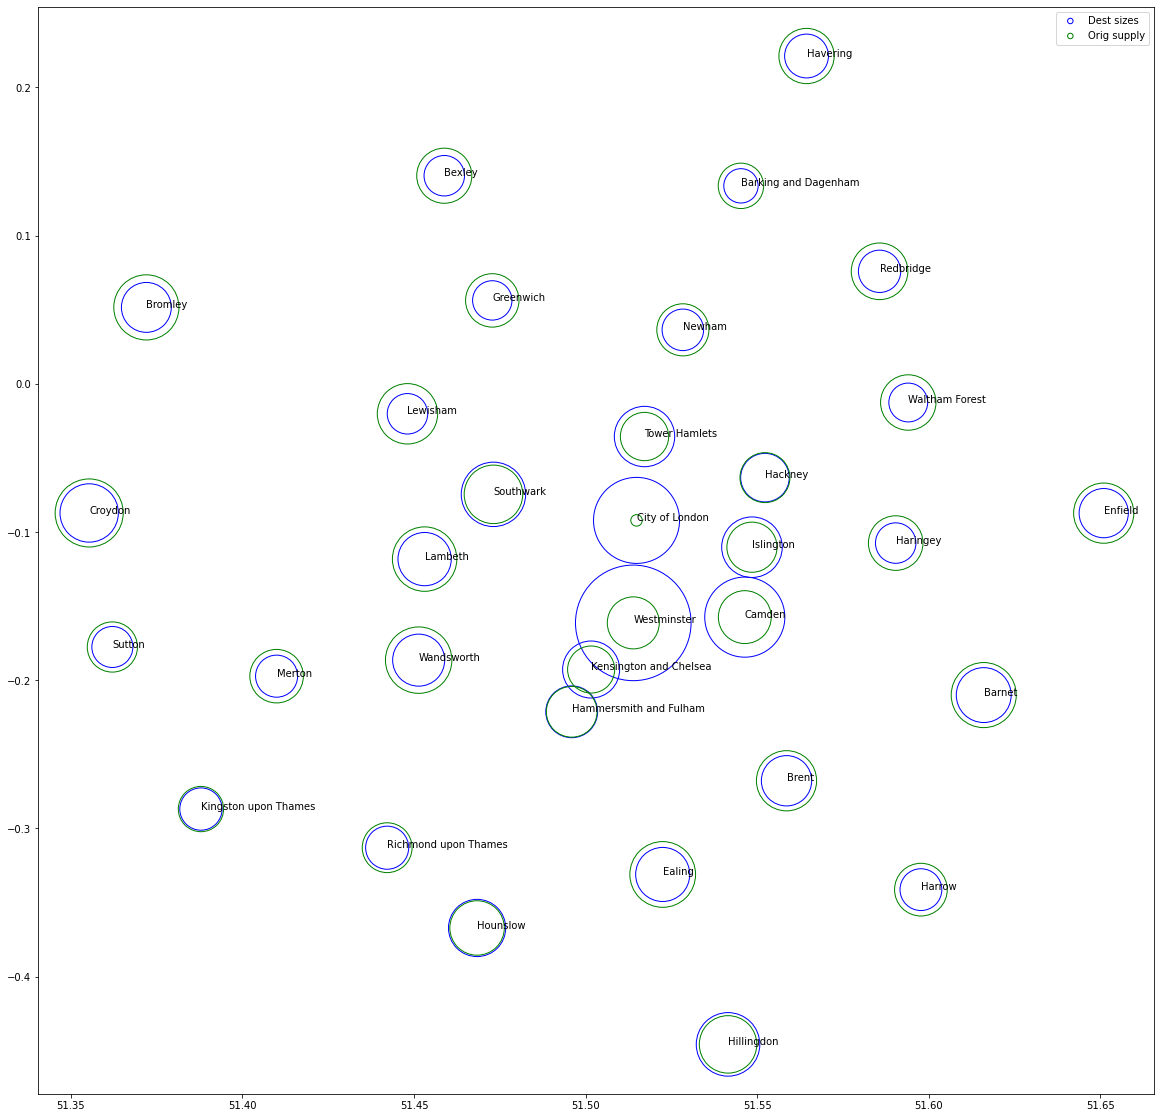

In [56]:
plt.figure(figsize=(20,20))
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*np.exp(init_year_array), alpha=1,label='Dest sizes')
# plt.scatter(destination_locs[:, 1], destination_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*dest_demand_normalised, alpha=1,label='Dest demand')
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*orig_supply_normalised, alpha=1,label='Orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

for i in range(len(destination_locs)):
#     print(np.sort(boroughs)[i],"=",str(i))
    plt.annotate(np.sort(boroughs)[i], (origin_locs[:, 1][i], origin_locs[:, 0][i]))

In [57]:
# Select borough
b = 16

print(boroughs[b])
print(latent_factor*np.exp(init_year_array)[b]/(actual_factor*orig_supply_normalised[b]))

Waltham Forest
1.2237895825781837


## Quick experiment on limit

In [80]:
# Import cost_matrix
c_ij = np.loadtxt('../data/validation/commuter/cost_matrix.txt')
x_d = np.exp(init_year_array)
N,M = c_ij.shape

In [178]:
def f(a,b,d,k):
    limit = np.zeros(M)
    for j in range(N):
        for i in range(N):
            numerator,denominator = 0,0
            for jj in range(M):
                if j != jj:
                    numerator += np.exp(a*x_d[jj] - b*c_ij[i,jj])
                denominator += np.exp(a*x_d[jj] - b*c_ij[i,jj])
#             if i == N-1:
#                 print('j =',j,'ratio =',(1 - numerator/denominator))
            limit[j] += orig_supply_normalised[i] * (1 - numerator/denominator)
        limit[j] = np.log((limit[j] + d)/k)
        
    return limit

# def g(a,b,d,k):
#     limit = np.zeros(M)
#     for j in range(N):
#         numerator,denominator = 0,0
#         for jj in range(M):
#             if j == jj:
#                 numerator += np.exp(a*x_d[jj] - b*c_ij[i,jj])
#             denominator += np.exp(a*x_d[jj] - b*c_ij[i,jj])
#         limit[j] = (numerator/denominator + d) / k

#     return limit

In [182]:
alpha = 0.01
beta = 0.01
delta = 0.3/M
kappa = 1.3

In [183]:
x_d_pred = f(alpha,beta,delta,kappa)
w_d_pred = np.exp(x_d_pred)

In [184]:
print(w_d_pred)
print('Sum',np.sum(w_d_pred))

[0.03028307 0.03030374 0.03028249 0.03030345 0.0302903  0.03032412
 0.03032793 0.03030249 0.03029658 0.03029958 0.03029712 0.03031243
 0.03031265 0.03030869 0.03028759 0.03026747 0.03027734 0.03029019
 0.03031811 0.03031688 0.03029298 0.03031572 0.03030617 0.0303059
 0.030301   0.03029132 0.03029535 0.03031839 0.03029948 0.03031477
 0.03030145 0.03031335 0.03034191]
Sum 0.9999999999999998


In [185]:
np.corrcoef(x_d,x_d_pred)[0,1]

0.6609618076728058

In [186]:
w_d = np.exp(x_d)
w_d_centred = w_d - np.mean(w_d)
ss_tot = np.dot(w_d_centred, w_d_centred)

res = w_d_pred - w_d
ss_res = np.dot(res, res)
print(1. - ss_res/ss_tot)

-1718.3347053614389


In [124]:
g(.01,.01,0.3/M)

array([0.03933813, 0.0394067 , 0.03933672, 0.0394042 , 0.03935381,
       0.03946422, 0.03944229, 0.03938304, 0.03938345, 0.03938724,
       0.03936164, 0.03940835, 0.03943184, 0.0394118 , 0.03936979,
       0.03931722, 0.03934981, 0.03937031, 0.0394354 , 0.03945373,
       0.03937712, 0.03942542, 0.03938492, 0.03940437, 0.03936983,
       0.03935411, 0.03938101, 0.03941829, 0.03938619, 0.03940309,
       0.03937954, 0.03942905, 0.03947738])

In [122]:
np.corrcoef(x_d,orig_supply_normalised)

array([[ 1.        , -0.21067813],
       [-0.21067813,  1.        ]])

# Quick viz

In [197]:
r2_values = np.loadtxt('../data/output/commuter/inverse_problem/singly_rsquared_analysis_100.txt')
with open('../data/output/commuter/inverse_problem/figures/singly_rsquared_analysis_gamma_100_parameters.json') as json_file:
    metadata = json.load(json_file)
grid_n = metadata['grid_size']
amin = metadata['amin']
amax = metadata['amax']
bmin = metadata['bmin']
bmax = metadata['bmax']
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
XX, YY = np.meshgrid(alpha_values, beta_values)

idx = np.unravel_index(r2_values.argmax(), r2_values.shape)
print("Fitted alpha and beta values:")
print(XX[idx], YY[idx]*amax/bmax, r2_values[idx])

Fitted alpha and beta values:
1.102 0.042 0.7710329773396047


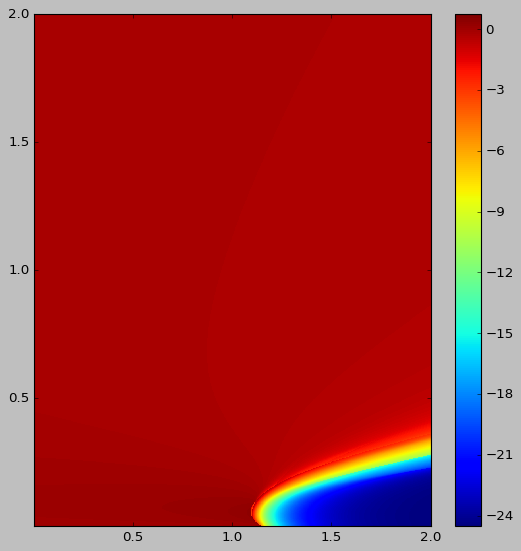

In [202]:
plt.style.use('classic')
fig = plt.figure(figsize=(8,8))
fig.tight_layout(pad=0.5)
plt.pcolor(XX, YY*amax/bmax, r2_values)
plt.xlim([np.min(XX), np.max(XX)])
plt.ylim([np.min(YY)*amax/bmax, np.max(YY)*amax/bmax])
plt.colorbar()
plt.savefig('../data/output/commuter/inverse_problem/figures/singly_rsquared_analysis_gamma_100.png')

# Retail data

## Import retail data

In [193]:
data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
retail_wd0 = np.exp(np.loadtxt("../cities_and_regions/data/london_n/xd0.txt"))
retail_orig_supply = popn[:, 2]/popn[:, 2].sum()
ret_locs = data[:, [0, 1]]
res_locs = popn[:, [0, 1]]

## Plot retail data

In [202]:
# Set plot params
latent_factor = 1000
actual_factor = 10000

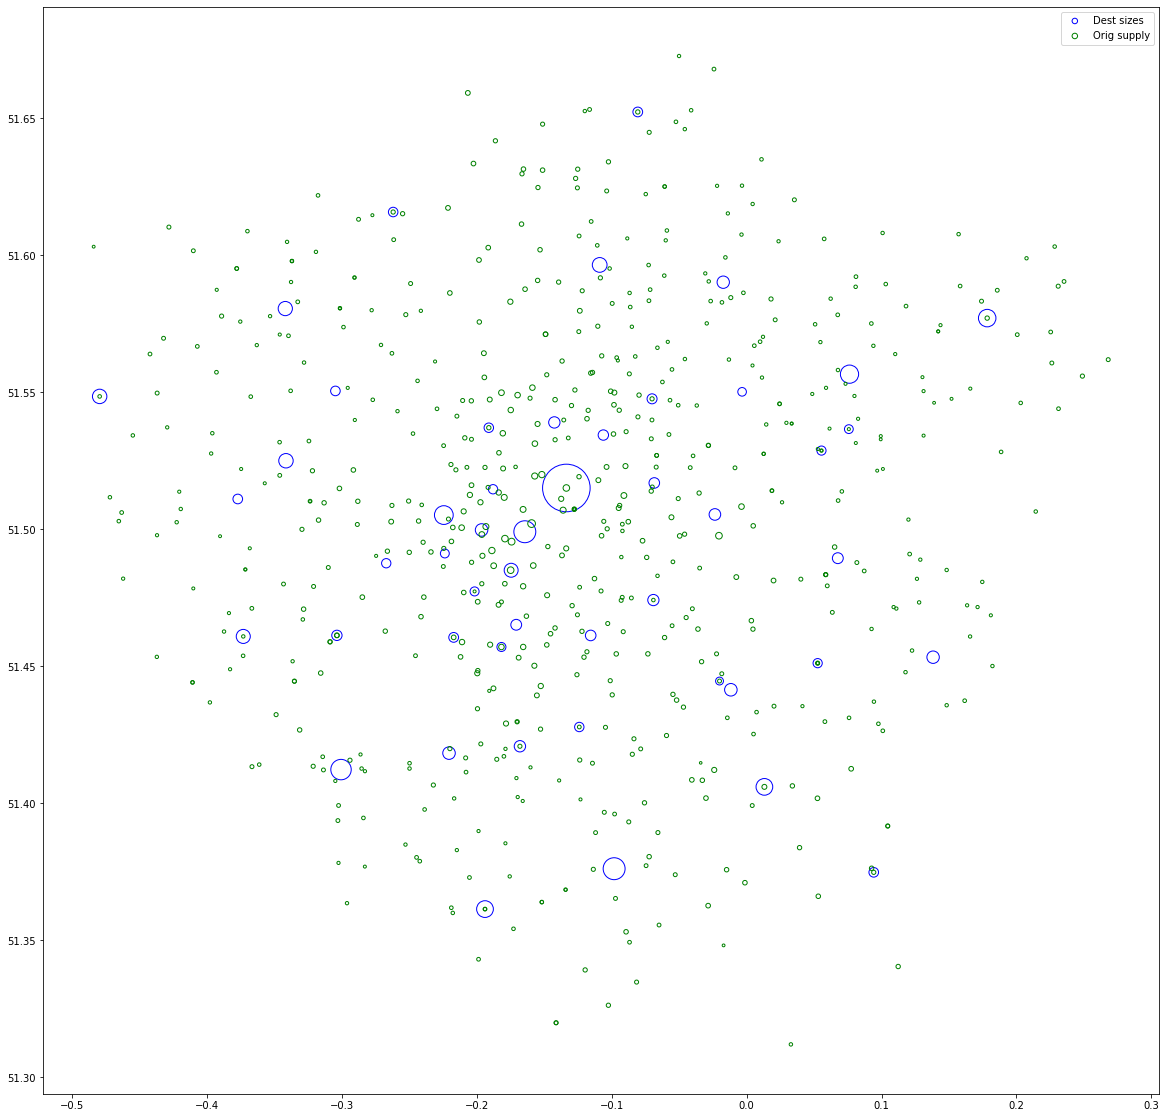

In [203]:
plt.figure(figsize=(20,20))
plt.scatter(ret_locs[:, 1], ret_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*retail_wd0, alpha=1,label='Dest sizes')
plt.scatter(res_locs[:, 1], res_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*retail_orig_supply, alpha=1,label='Orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

# Export data

In [19]:
# Save to txt
np.savetxt(f'../data/input/{dataset}/initial_destination_sizes.txt',init_year_array)
np.savetxt(f'../data/input/{dataset}/final_destination_sizes.txt',final_year_array)

In [20]:
# Export semantic meaning of destination sizes
with open(f"../data/input/{dataset}/destination_sizes_info.txt", "w") as text_file:
    print(f"destination_sizes_data_filepath,{filepath}", file=text_file)
    print(f"destination_sizes_variable,{var}", file=text_file)
    print(f"initial_destination_sizes_year,{str(init_year)}", file=text_file)
    print(f"final_destination_sizes_year,{str(final_year)}", file=text_file)